In [599]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using LinearAlgebra
using Printf
import ForwardDiff as FD
using JuMP
using COSMO
using Random; 

  Activating environment at `~/SSD/Code/TinyMPC/julia/cone_simple/Project.toml`


In [674]:
# -------------------THIS IS ALL ALTRO-------------------------------
# This enables goal equality constraints, state and input ineq constraints.

function stage_cost(p::NamedTuple,x,u,k)
    dx = x - p.Xref[k]
    du = u - p.Uref[k]
    return 0.5*dx'*p.Q*dx + 0.5*du'*p.R*du
end
function term_cost(p::NamedTuple,x)
    dx = x - p.Xref[p.N]
    return 0.5*dx'*p.Qf*dx
end
function stage_cost_expansion(p::NamedTuple,k)
    dx = - p.Xref[k]
    du = - p.Uref[k]
    return p.Q, p.Q*dx, p.R, p.R*du  # Hessian and gradient
end
function term_cost_expansion(p::NamedTuple)
    dx = - p.Xref[p.N]
    return p.Qf, p.Qf*dx
end
function conic_cost_expansion(p::NamedTuple, u, λc, ρ, k)
    λhat = λc # already updated
    ∇c = cone_u_jac(p, u)
    G = ∇c'*∇projection(λhat)*projection(λhat)
    # H = ∇c'*∇projection(λhat)'*∇projection(λhat)*∇c/ρ
    H = ∇c'*(∇projection(λhat)'*∇projection(λhat) + ∇²projection(λhat, projection(λhat)))*∇c/ρ
    return (G - H*u), H
end
function backward_pass!(params,X,U,P,p,d,K,reg,μ,μx,ρ,λ,λc)
    """iLQR backward pass with AL. This !function update its parameters
    """
    N = params.N
    ΔJ = 0.0    # expected cost reduction

    # terminal cost expansion
    P[N], p[N] = term_cost_expansion(params) 
    
    if (params.ncx > 0)
        # # add AL terms for the state constraint at the final time step
        hxv = ineq_con_x(params,X[N])  # h(x) violation  
        mask = eval_mask(μx[N],hxv)
        ∇hx = ineq_con_x_jac(params,X[N])
        # add these into the cost-to-go p and P
        p[N]  += ∇hx'*(μx[N] - ρ*(mask * [params.x_max;-params.x_min]))  # multiplier term (1st)
        P[N]  += ρ*∇hx'*mask*∇hx                # penalty term (2nd)
    end
    
    if (params.ncg > 0)
        # add AL terms for goal constraint 
        ∇hx = diagm(ones(params.nx))
        # add these into the CTG p and P (equality active)
        p[N]  += ∇hx'*(λ - ρ*params.Xref[N])   
        P[N]  += ρ*∇hx'∇hx
    end
    
    # iterate from N-1 to 1 backwards
    for k = (N-1):(-1):1
        # dynamics jacobians (linearization about previous iterate)
        A = FD.jacobian(_x -> discrete_dynamics(params,_x,U[k],k),X[k])
        B = FD.jacobian(_u -> discrete_dynamics(params,X[k],_u,k),U[k])

        Sxx,Sx,Suu,Su = stage_cost_expansion(params,k)
        
        # one-step cost expansion: Q, Q*dx, R, R*du
        Sx += A' * (P[k+1]*f + p[k+1]) 
        Su += B' * (P[k+1]*f + p[k+1]) 
        Sxx += A'*(P[k+1])*A
        Suu += B'*(P[k+1] + reg*I)*B                                     
        Sux = B'*(P[k+1])*A  
        if (params.ncu > 0)
            # control constraints
            huv = ineq_con_u(params,U[k])  # calculate h(u) constraint
            mask = eval_mask(μ[k],huv)  # choose active
            ∇hu = ineq_con_u_jac(params,U[k])
            Su  += ∇hu'*(μ[k] - ρ*(mask * [params.u_max;-params.u_min])) # add to cost
            Suu += ρ*∇hu'*mask*∇hu
        end
        if (params.ncx > 0)
            # state constraints
            hxv = ineq_con_x(params,X[k])
            mask = eval_mask(μx[k],hxv)
            ∇hx = ineq_con_x_jac(params,X[k])
            Sx  += ∇hx'*(μx[k] - ρ*(mask * [params.x_max;-params.x_min]))
            Sxx += ρ*∇hx'*mask*∇hx
        end
        if (params.ncu_cone > 0)
            # conic constraints
            Qu, Quu = conic_cost_expansion(params, U[k], λc[k], ρ/cone_scale, k)
            # display(Quu)
            Su += Qu
            Suu += Quu
        end
        
        # Calculate Gains
        for i = 1:10
            if isposdef(Suu) == 0
                Suu += reg*I
            end
        end
        F = cholesky(Symmetric(Suu))
        d[k] = F\Su
        K[k] = F\Sux

        # Cost-to-go Recurrence (PSD stabilizing version, last term)
        P[k] = Sxx + K[k]'*Suu*K[k] - 2*K[k]'*Sux
        p[k] = Sx + K[k]'*Suu*d[k] - K[k]'*Su - Sux'*d[k]
        ΔJ += Su'*d[k]
    end

    return ΔJ  # but also change params
end
function forward_pass!(params,X,U,K,d,ΔJ,Xn,Un,μ,μx,ρ,λ; 
                        max_linesearch_iters = 20)
    """iLQR forward pass and line-search
    This !function update its parameters
    """
    N = params.N
        # Forward Rollout
        for k = 1:(N-1)
            Un[k] = - d[k] - K[k]*Xn[k] 
            Xn[k+1] = discrete_dynamics(params,Xn[k],Un[k],k)
        end
    X .= Xn
    U .= Un
    return 0, 0
end
function eval_mask(μv,huv)  
    # Extract active inequality constraints
    # active set mask
    mask = Diagonal(zeros(length(huv)))
    for i = 1:length(huv)
        mask[i,i] = (μv[i] > 0 || huv[i] > 0)
    end
    mask
end
function mpc(params,X,U,P,p,K,d,Xn,Un;atol=1e-3,max_iters = 250,verbose = true,ρ=1,ϕ=10)

    # first check the sizes of everything
    # @assert length(X) == params.N
    # @assert length(U) == params.N-1
    # @assert length(X[1]) == params.nx
    # @assert length(U[1]) == params.nu

    # initial rollout
    N = params.N
    for i = 1:N-1
        X[i+1] = discrete_dynamics(params,X[i],U[i],i)
    end

    reg_min = 1e-8
    reg = reg_min

    μ = [zeros(params.ncu) for i = 1:N-1]   # input constraints

    μx = [zeros(params.ncx) for i = 1:N]    # state constraints

    λ = zeros(params.nx)    # goal constraint

    λc = [zeros(params.ncu_cone) for i = 1:N-1]   # goal constraint
    
    # Inner loop to solve unconstrained problem (Riccati)
    for iter = 1:max_iters
        
        J = 0.0
        ΔJ = 0.0
        α = 1.0
        for i = 1:1
            ΔJ = backward_pass!(params,X,U,P,p,d,K,reg,μ,μx,ρ,λ,λc)
            J, α = forward_pass!(params,X,U,K,d,ΔJ,Xn,Un,μ,μx,ρ,λ)
        end

        if verbose
            if rem(iter-1,10)==0
                @printf "iter     J           ΔJ        |d|         α        reg         ρ\n"
                @printf "---------------------------------------------------------------------\n"
            end
            @printf("%3d   %10.3e  %9.2e  %9.2e  %6.4f   %9.2e   %9.2e\n",
              iter, J, ΔJ, 0, α, reg, ρ)
        end
        # update multipliers and check constraint violation, max of all
        convio = 0  
        
        if (params.ncu > 0)
            # control constraints (inequality)
            for k = 1:N-1
                huv = ineq_con_u(params,U[k])
                mask = eval_mask(μ[k],huv)
                # update dual
                convio = max(convio,norm(huv + abs.(huv),Inf))
                μ[k] = max.(0,μ[k] - ρ*(mask * [params.u_max;-params.u_min]))
            end
        end
        if (params.ncx > 0)
            # state constraints (inequality)
            for k = 1:N
                hxv = ineq_con_x(params,X[k])
                mask = eval_mask(μx[k],hxv)
                # update dual
                convio = max(convio,norm(hxv + abs.(hxv),Inf))
                μx[k] = max.(0,μx[k] - ρ*(mask * [params.x_max;-params.x_min]))                
            end
        end
        if (params.ncu_cone > 0)
            # conic constraints 
            if verbose
                print("update cone\n")
            end            
            for k = 1:N-1
                # update dual
                Uc = cone_u(params, U[k])
                huc = norm(Uc[1:2]) - Uc[3]
                convio = max(convio, norm(huc + abs.(huc),Inf))
                λc[k] = projection(λc[k] + Uc/cone_scale/ρ)
                # display(λc[k])
            end
        end
        if (params.ncg > 0)
            # goal constraint (equality)
            hxv = X[N] - params.Xref[N]
            λ .-= ρ*params.Xref[N]
            convio = max(convio, norm(hxv,Inf))
        end
        
        ρ *= ϕ  # update penalty
        
        if verbose
            @show convio
        end
        if convio < atol  # if terminal condition with contraint violation
            # print("Our solver says SUCCESS\n") # @info "success!"
            return U[1]
        end
        if ρ > 1e5
            print("Our solver reachs MAX PENALTY\n")
            return U[1]
        end
    end
    print("Our solver says INFEASIBLE and MAX ITER\n")
    return U[1]
end
#----------------------ALTRO DONE --------------------------

mpc (generic function with 1 method)

In [601]:
# =============================
# Example problem formulation and solve
# =============================

# ---------------------THIS IS WHAT YOU NEED TO INPUT--------
A = [1.0 0.0 0.0 0.05 0.0 0.0; 
    0.0 1.0 0.0 0.0 0.05 0.0; 
    0.0 0.0 1.0 0.0 0.0 0.05; 
    0.0 0.0 0.0 1.0 0.0 0.0; 
    0.0 0.0 0.0 0.0 1.0 0.0; 
    0.0 0.0 0.0 0.0 0.0 1.0]
B = [0.000125 0.0 0.0; 
    0.0 0.000125 0.0;
    0.0 0.0 0.000125; 
    0.005 0.0 0.0; 
    0.0 0.005 0.0; 
    0.0 0.0 0.005]
f = [0.0, 0.0, -0.0122625, 0.0, 0.0, -0.4905]
function discrete_dynamics(p::NamedTuple,x,u,k)
    A = [1.0 0.0 0.0 0.05 0.0 0.0; 
        0.0 1.0 0.0 0.0 0.05 0.0; 
        0.0 0.0 1.0 0.0 0.0 0.05; 
        0.0 0.0 0.0 1.0 0.0 0.0; 
        0.0 0.0 0.0 0.0 1.0 0.0; 
        0.0 0.0 0.0 0.0 0.0 1.0]
    B = [0.000125 0.0 0.0; 
        0.0 0.000125 0.0;
        0.0 0.0 0.000125; 
        0.005 0.0 0.0; 
        0.0 0.005 0.0; 
        0.0 0.0 0.005]
    f = [0.0, 0.0, -0.0122625, 0.0, 0.0, -0.4905]
    return A*x + B*u + f
end
function ineq_con_x(p,x)
    [x-p.x_max;-x + p.x_min]
end
function ineq_con_u(p,u)
    [u-p.u_max;-u + p.u_min]
end
function cone_u(p, u)
    [p.A_cone*u;p.c_cone'*u]
end
function cone_u_jac(p, u)
    J = zeros(p.nu, p.nu)
    J[1:end-1,1:end] .= p.A_cone
    J[end,1:end] .= p.c_cone
    return J
end
function ineq_con_u_jac(params,u)
    FD.jacobian(_u -> ineq_con_u(params,_u), u)
end
function ineq_con_x_jac(p,x)
    FD.jacobian(_x -> ineq_con_x(p,_x),x)
end
function projection(x)
    n = length(x)
    s = x[end]
    v = view(x,1:n-1)
    a = norm(v)
    if a <= -s  # below the cone
        return zero(x)
    elseif a <= s  # in the code
        return x
    elseif a >= abs(s)  # outside the cone
        return 0.5 * (1 + s/a) * [v; a] 
    end
end
function ∇projection(x)
    n = length(x)
    J = zeros(eltype(x),n,n)
    s = x[end]
    v = view(x,1:n-1)
    a = norm(v)
    if a <= -s
        return J  # zeros
    elseif a <= s
        J .= I(n)  
        return J  # identity
    elseif a >= abs(s)
        c = 0.5 * (1 + s/a)

        # dvdv ok!
        for i = 1:n-1, j = 1:n-1
            J[i,j] = -0.5*s/a^3 * v[i] * v[j]
            if i == j
                J[i,j] += c
            end
        end

        # dvds ok!
        for i = 1:n-1
            J[i,n] = 0.5 * v[i] / a
        end

        # dsdv ok!
        for i = 1:n-1
            J[n,i] = ((-0.5*s/a^2) + c/a) * v[i]
        end
        J[n,n] = 0.5  # ok
        return J
    else
        error("Invalid second-order cone projection.")
    end
    return J
end
function ∇²projection(x, b)
    n = length(x)
    hess = zeros(eltype(x),n,n)
    v = view(x, 1:n)
    bv = view(b, 1:n)

    n = length(x)-1
    # @assert size(hess) == (n+1,n+1)
    s = x[end]
    bs = b[end]
    a =  norm(v)
    vbv = dot(v,bv)

    if a <= -s
        return hess .= 0
    elseif a <= s
        return hess .= 0
    elseif a > abs(s)
        # Original equations from chain rule
        # n = n + 1
        # dvdv = -s/norm(v)^2/norm(v)*(I - (v*v')/(v'v))*bv*v' + 
        #     s/norm(v)*((v*(v'bv))/(v'v)^2 * 2v' - (I*(v'bv) + v*bv')/(v'v)) + 
        #     bs/norm(v)*(I - (v*v')/(v'v))
        # dvds = 1/norm(v)*(I - (v*v')/(v'v))*bv;
        # hess[1:n-1,1:n-1] .= dvdv*0.5
        # hess[1:n-1,n] .= dvds*0.5
        # hess[n:n,1:n-1] .= 0.5*dvds'
        # hess[n,n] = 0
        # return hess

        # The following is just an unrolled version of the above
        dvdv = view(hess, 1:n, 1:n)
        dvds = view(hess, 1:n, n+1)
        dsdv = view(hess, n+1, 1:n)
        @inbounds for i = 1:n
            hi = 0
            @inbounds for j = 1:n
                Hij = -v[i]*v[j] / a^2
                if i == j
                    Hij += 1
                end
                hi += Hij * bv[j]
            end
            dvds[i] = hi / 2a
            dsdv[i] = dvds[i]
            @inbounds for j = 1:i
                vij = v[i] * v[j]
                H1 = hi * v[j] * (-s/a^3)
                H2 = vij * (2*vbv) / a^4 - v[i] * bv[j] / a^2
                H3 = -vij / a^2
                if i == j
                    H2 -= vbv / a^2
                    H3 += 1
                end
                H2 *= s/a
                H3 *= bs/a
                dvdv[i,j] = (H1 + H2 + H3) / 2
                dvdv[j,i] = dvdv[i,j]
            end
        end
        hess[end,end] = 0
        return hess
    else
        throw(ErrorException("Invalid second-order cone projection"))
    end
end

∇²projection (generic function with 1 method)

In [602]:
∇²projection([1.1 2 0], [4.1 5 6])

3×3 Matrix{Float64}:
  1.00908   -0.554993   0.227043
 -0.554993   0.305246  -0.124873
  0.227043  -0.124873   0.0

iter     J           ΔJ        |d|         α        reg         ρ
---------------------------------------------------------------------
  1    0.000e+00   3.56e+06   0.00e+00  0.0000    1.00e-08    1.00e+00
update cone
convio = 29.899759669898994
  2    0.000e+00   3.60e+06   0.00e+00  0.0000    1.00e-08    1.00e+01
update cone
convio = 29.393736451782093
  3    0.000e+00   3.82e+06   0.00e+00  0.0000    1.00e-08    1.00e+02
update cone
convio = 25.216116220518987
  4    0.000e+00   3.74e+06   0.00e+00  0.0000    1.00e-08    1.00e+03
update cone
convio = 11.458491210588882
  5    0.000e+00   3.19e+06   0.00e+00  0.0000    1.00e-08    1.00e+04
update cone
convio = 1.8108362724707319
  6    0.000e+00   3.08e+06   0.00e+00  0.0000    1.00e-08    1.00e+05
update cone
convio = 0.19233046016561572
  7    0.000e+00   3.30e+06   0.00e+00  0.0000    1.00e-08    1.00e+06
update cone
convio = 0.019353348696721118
  8    0.000e+00   5.51e+06   0.00e+00  0.0000    1.00e-08    1.00e+07
update cone
c

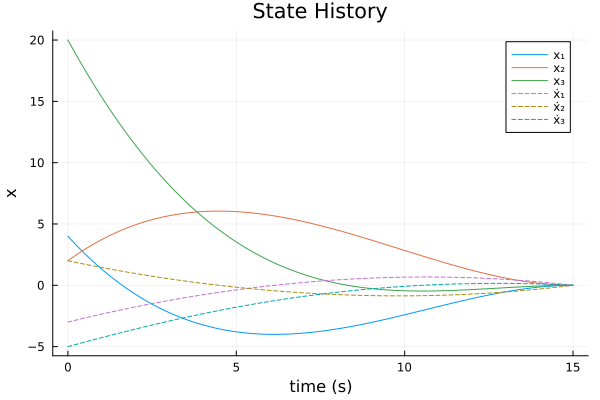

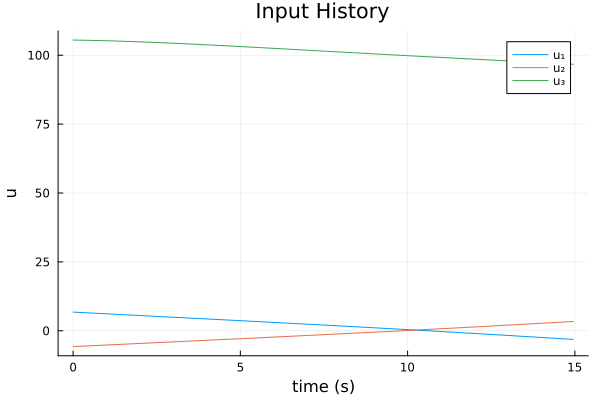

In [666]:
# Let's solve

nx = 6
nu = 3
N = 301
dt = 0.05
t_vec = dt*(0:N-1)
x0 = [4, 2, 20, -3, 2, -5.0]
xg = [0,0,0,0,0,0.0]
Xref = [deepcopy(xg) for i = 1:N]
Uref = [zeros(nu) for i = 1:N-1]

Q = 1e-1*I(nx)
R = 1e-0*I(nu)
Qf = 100*I(nx)

# ground_level = 0.0
gravity = [0; 0; -9.81]
mass = 10.0
# ωPlanet = [0.0; 0.0; 0.0]
perWeightMax = 2.0
θ_thrust_max = 5.0  # deg
# θ_glideslope = 60.0 # deg
# glide_recover_k = 8

A_cone = [1 0 0; 0 1 0]
c_cone = [0.0, 0.0, tand(θ_thrust_max)]
u_bnd = mass * abs(gravity[3]) * perWeightMax
u_min = -170*ones(nu)
u_max =  170*ones(nu)

# state is x y v θ
x_min = [-5,-5,0,-10,-10,-10.0]
x_max = [5,5,20,10,10,10.0]

ncx = 2*nx*0
ncu = 2*nu*0
ncg = 1
ncu_cone = nu*1; 
cone_scale = 1  # very fragile for each problem

params = (
    nx = nx,
    nu = nu,
    ncx = ncx,
    ncu = ncu,
    ncg = ncg,
    ncu_cone = ncu_cone,
    A_cone = A_cone,
    c_cone = c_cone,
    N = N,
    Q = Q,
    R = R,
    Qf = Qf,
    u_min = u_min,
    u_max = u_max,
    x_min = x_min,
    x_max = x_max,
    Xref = Xref,
    Uref = Uref,
    dt = dt,
    mc = 1.0,
    mp = 0.2,
    l = 0.5,
    g = 9.81,
);

# previous iterate
X = [deepcopy(x0) for i = 1:N]
U = [zeros(nu) for k = 1:N-1]
# X = Xref*1
# U = Uref*1
# new iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
p = [zeros(nx) for i = 1:N]      # cost to go linear term
d = [zeros(nu) for i = 1:N-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:N-1] # feedback gain
u_ = mpc(params,X,U,P,p,K,d,Xn,Un; atol=1e-4, max_iters = 20, verbose = true, ρ = 1e0, ϕ = 10.0);
function mat_from_vec(X::Vector{Vector{Float64}})::Matrix
    # convert a vector of vectors to a matrix 
    Xm = hcat(X...)
    return Xm 
end
Xsim_m = mat_from_vec(Xn)
Usim_m = mat_from_vec(Un)
using Plots
display(plot(t_vec,Xsim_m',label = ["x₁" "x₂" "x₃" "ẋ₁" "ẋ₂" "ẋ₃"],linestyle=[:solid :solid :solid :dash :dash :dash],
             title = "State History",
             xlabel = "time (s)", ylabel = "x"))
display(plot(t_vec[1:end-1],Usim_m',label = ["u₁" "u₂" "u₃"],
             title = "Input History",
             xlabel = "time (s)", ylabel = "u"))

For TrajOpt, it needs more tricks to get better results:
- Hessian of the projection => better approximation (done)
- Scaling between conic constraints and other ones (1/rho, Zac did not buy it)
- Solution polishing?

Maybe, we don't care about TrajOpt problem, except from a good initial guess, there is nothing we can tune to get better performance. How about reset mpc?

In [667]:
# Check conic violation
convio = 0.0
for k = 1:N-1
    Uc = cone_u(params, U[k])
    huc = norm(Uc[1:2]) - Uc[3]
    convio = norm(huc + abs.(huc),Inf)
    display(huc) # should <= 0
end
Xref .= Xn;
Uref .= Un;

-0.34275803408714545

-0.38432830727138345

-0.4258564126514024

-0.46734292435859537

-0.5087883683776049

-0.5501932861356487

-0.5915582381431062

-0.6328837328354933

-0.6741703252088893

-0.7154185395232364

-0.7566289052684922

-0.7978019532099481

-0.8389381956189759

-0.8800381531551587

-0.9211023660636357

-0.9621313222927625

-1.0031255567397022

-1.0440855241613267

-1.0850118982549244

-1.1259049562555692

-1.166765441639484

-1.207593623065633

-1.248390178160931

-1.289155599328164

-1.329890234826645

-1.3705947816933453

-1.4112695919257243

-1.4519151961352161

-1.4925320864765235

-1.533120772689851

-1.5736817246612373

-1.6142154371457131

-1.6547223399890534

-1.6952030833023928

-1.7356579808142243

-1.776087588025269

-1.8164923675567515

-1.8568728058025679

-1.8972293764082542

-1.937562573730963

-1.9778728585040612

-2.018160712259208

-2.0584266108377482

-2.0986710265743733

-2.138894434927633

-2.1790973085767273

-2.2192801181578448

-2.259443329047296

-2.2995874312694147

-2.339712869433712

-2.3798201303066673

-2.4199096843918957

-2.4599819807265613

-2.5000375047883

-2.540076723010726

-2.5801000869487627

-2.620108077338273

-2.660101156781466

-2.7000797399824528

-2.740044438668524

-2.7799955781436063

-2.819933658275941

-2.8598591509885285

-2.8997725182434184

-2.9396742187044937

-2.9795647310650173

-3.0194444979480615

-3.0593140027037604

-3.099173687064509

-3.13902403307896

-3.17886548219452

-3.2186985162967785

-3.2585235776345476

-3.298341146224919

-3.338151662342611

-3.3779556079708897

-3.4177534274917143

-3.4575455813938625

-3.497332543143176

-3.5371147519763753

-3.5768926831828187

-3.6166667885888906

-3.656437531517664

-3.696205359679986

-3.7359707343995643

-3.775734071636368

-3.8154959515109894

-3.8552567038058587

-3.8950168249052544

-3.934776767987155

-3.974536982734203

-4.014297928927241

-4.054060052907245

-4.093823805593427

-4.133589601111359

-4.173357994731753

-4.213129315675841

-4.252904018568152

-4.292682662205635

-4.332465526080247

-4.372253207175036

-4.4120460292412185

-4.45184446351279

-4.4916489551482295

-4.5314599247613305

-4.5712778046080365

-4.611103017581866

-4.6509359959081245

-4.690777160306915

-4.730626920062683

-4.770485693054038

-4.810353890982364

-4.850231919124234

-4.8901201802253285

-4.930019068171115

-4.969928984000063

-5.009850315608483

-5.049783437685418

-5.089728697084185

-5.1296865620099545

-5.169657306422392

-5.209641309568907

-5.249638924302724

-5.289650493122295

-5.329676347730606

-5.369716812189194

-5.409772196795302

-5.449842815627694

-5.4899289512273395

-5.530030886661951

-5.5701488897194995

-5.610283215606649

-5.650434099427423

-5.690601775973972

-5.730786442140785

-5.770988290815964

-5.8112074922042005

-5.851444195571132

-5.891698528994949

-5.93197059608743

-5.972260473912225

-6.012568213818151

-6.052893836467878

-6.093237329844895

-6.1335986479041065

-6.173977707728289

-6.214374384974873

-6.2547885116831825

-6.295219872254998

-6.335668199631083

-6.3761331696541665

-6.4166143974675105

-6.457111432203273

-6.497623722984352

-6.5381507419401785

-6.578691720678921

-6.619245894816904

-6.65981235436367

-6.700390155483808

-6.740978089880388

-6.781574903826752

-6.822179161867724

-6.862789253979719

-6.9034033784058035

-6.944019516026044

-6.984635408763784

-7.0252485273343925

-7.065856040619578

-7.1064547544098

-7.147041178021796

-7.187611253397

-7.228160516073678

-7.2686838948892305

-7.30917576056748

-7.349629619541561

-7.390038214134252

-7.430393285350245

-7.470685439058417

-7.510903959057364

-7.551036585224066

-7.591069243281156

-7.630985703714715

-7.670767279867706

-7.7103921578960675

-7.74983499405427

-7.78906607156474

-7.828050505094278

-7.866746932059195

-7.905106264360439

-7.943069909141703

-7.980567363510091

-8.01751364550454

-8.053805479017935

-8.089316992454833

-8.123894035873068

-8.157347297915628

-8.189444111345852

-8.219898947257466

-8.248363527180425

-8.27441824315839

-8.297568037935198

-8.317248328867763

-8.332848173864008

-8.343757341644723

-8.349438108211116

-8.34951008988464

-8.343822521422428

-8.332484942872009

-8.315842378550379

-8.2944065565909

-8.268771469012966

-8.239539802536614

-8.207273337403297

-8.172467539603272

-8.135544023370887

-8.096853630231227

-8.056684531585573

-8.015271869472429

-7.972807095743012

-7.929446211138333

-7.885316678580731

-7.840523061606365

-7.795151549804307

-7.749273560203438

-7.702948592692118

-7.656226492850692

-7.609149247776454

-7.561752415588852

-7.514066267606946

-7.466116704995582

-7.417925997906856

-7.369513384438289

-7.320895558434035

-7.272087068756225

-7.223100647719885

-7.173947482579361

-7.1246374410119016

-7.075179259262941

-7.025580699842947

-6.975848684279461

-6.92598940534075

-6.876008422291367

-6.825910742005365

-6.775700888680521

-6.725382962872275

-6.674960693412006

-6.624437481509447

-6.573816439230129

-6.523100423361692

-6.4722920638917465

-6.421393790338907

-6.370407854306925

-6.3193363469545965

-6.268181221607906

-6.21694430262103

-6.165627304475643

-6.1142318411124705

-6.062759437295234

-6.011211539890535

-5.959589522917192

-5.907894699873419

-5.85612832751824

-5.804291612677263

-5.75238571941101

-5.70041177307332

-5.648370865052219

-5.596264056883468

-5.544092384694843

-5.491856866567589

-5.439558486308062

-5.3871982341531215

-5.334777072514926

-5.282295956598464

-5.2297558337254575

-5.177157644625843

-5.12450232600659

-5.0717908121910735

-5.019024036564658

-4.966202934009116

-4.91332844178241

-4.860401500957252

-4.807423058804123

-4.75439406815193

-4.701315490673705

-4.6481882971793596

-4.595013469091548

-4.54179199973572

-4.488524895662372

-4.435213178023142

-4.381857884025747

-4.328460068495188

-4.275020805572414

-4.221541190584539

-4.168022342163262

-4.1144654043734725

-4.06087154976411

-4.007241981747914

-3.953577938291673

-3.899880695541367

-3.8461519563001216

In [675]:
### MPC style with other solver ###
include("mpc_JuMP.jl")

Nsim = 301
Nh = 21
t_vec = dt*(0:Nsim-1)

x0 = [4, 2, 20, -3, 2, -5.0]  # initial plan
# x0 = [5, 2, 21, -3, 2, -5.0]  # change this!
# x0 = [4.4, 2.2, 20.2, -3.03, 2.02, -5.05]

xg = [0,0,0,0,0,0.0]
Q = 100e-1*I(nx)  # make this higher!
R = 1e-1*I(nu)
Qf = 10*I(nx) # change this!
θ_thrust_max = 5.0  # increase max thrust from plan!

# state is x y v θ
x_min = [-5,-5,0,-10,-10,-10.0]
x_max = [5,5,20,10,10,10.0]

ncx = 2*nx*0
ncu = 2*nu*0
ncg = 0
ncu_cone = nu*1; 
cone_scale = 1e0

params = (
    nx = nx,
    nu = nu,
    ncx = ncx,
    ncu = ncu,
    ncg = ncg,
    ncu_cone = ncu_cone,
    A_cone = A_cone,
    c_cone = c_cone,
    N = Nh,
    Q = Q,
    R = R,
    Qf = Qf,
    u_min = u_min,
    u_max = u_max,
    x_min = x_min,
    x_max = x_max,
    Xref = Xref,
    Uref = Uref,
    dt = dt,
    mc = 1.0,
    mp = 0.2,
    l = 0.5,
    g = 9.81,
);

Xhist = [deepcopy(x0) for i = 1:Nsim]
Uhist = [-mass * gravity for k = 1:Nsim-1]
# previous iterate
X = [deepcopy(x0) for i = 1:Nh]
U = [-mass * gravity for k = 1:Nh-1]

# new iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:Nh]   # cost to go quadratic term
p = [zeros(nx) for i = 1:Nh]      # cost to go linear term
d = [zeros(nu) for i = 1:Nh-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:Nh-1] # feedback gain

optimizer = JuMP.optimizer_with_attributes(COSMO.Optimizer,
    "verbose"=>false,
    "eps_abs"=>1e-8,
    "eps_rel"=>1e-8,
    "rho"=>1e-2,
    "scaling"=>0,
    "alpha"=>1.0)
Random.seed!(1);
for i = 1:Nsim-Nh-1
    params1 = (; params..., Uref = Uref[i:Nh+i], Xref = Xref[i:Nh+i-1])  # update ref
    
    pos_norm = norm(Xhist[i][1:3], Inf) / 100 # 1% noise
    vel_norm = norm(Xhist[4:6], Inf) / 1e6 # 1ppm noise
    noise_pos = randn(3)
    noise_vel = randn(3)
    Xhist[i] += [noise_pos * pos_norm; noise_vel * vel_norm]
    
    # Uhist[i] = mpc_JuMP(optimizer, params1, Xhist[i], A, B, f)
    
    # X = [Xhist[i] for i = 1:Nh]  # reset, avoid warm-staring
    # U = [-mass * gravity for k = 1:Nh-1]
    X[1] .= Xhist[i]; Uhist[i] = mpc(params1,X,U,P,p,K,d,Xn,Un;atol=1e-4,max_iters = 10,verbose = false,ρ = 100, ϕ = 10.0) 
    
    Xhist[i+1] = discrete_dynamics(params1,Xhist[i],Uhist[i],i)  # dynamics
end

1. COSMO gives better tracking results
2. Ours always need warm-start

In [649]:
# Check conic violation
convio = 0.0
for k = 1:Nsim-1
    Uc = cone_u(params, Uhist[k])
    huc = norm(Uc[1:2]) - Uc[3]
    convio = norm(huc + abs.(huc),Inf)
    display(huc) # should <= 0
end

-0.34275803574771047

-0.5859821282258562

-0.8226138118415367

-1.0526187414344435

-1.2759560610967116

-1.4925778944195534

-1.702428821923382

-1.9054453552103938

-2.1015554210642646

-2.290677873315988

-2.472722055922291

-2.647587447464102

-2.815163425204645

-2.975329195889648

-3.1279539503958116

-3.272897309671147

-3.4100101393524094

-3.5391358187513084

-3.660112054806998

-3.7727733307843128

-3.876954070131247

-3.9724925748817723

-4.059235762356112

-4.137044671587753

-4.205800641662554

-4.265411980684429

-4.315820852961737

-4.4515950726515126

-4.48159167474254

-4.503619989335574

-4.51787358386157

-4.524356699115783

-4.523226259545195

-4.514898218289289

-4.499621284533493

-4.477633732128475

-4.449174143908023

-4.414847914138349

-4.37483252558968

-4.329609645847196

-4.279526602477141

-4.22506283899587

-4.166548595072838

-4.104376497221162

-4.0387668597131325

-3.9702709323685323

-3.8990528138355933

-3.825459582827685

-3.7496827747008656

-3.672091543311356

-3.613585421572665

-3.5335516196049443

-3.454525934382197

-3.3720703063489164

-3.2885743553209075

-3.2041485274535604

-3.1188873281884697

-3.0328706895235515

-2.946164654722229

-2.858819666730123

-2.7709098221700055

-2.682430906779574

-2.59339662056124

-2.5038187547340325

-2.413700972105694

-2.3230334082155313

-2.2318053470567083

-2.1399974262484864

-2.0476175067218607

-1.9546387429308894

-1.8610049088145804

-1.76667842910188

-1.6716243930581474

-1.5758053337703126

-1.4791800137708382

-1.381743046708479

-1.283482513892138

-1.1842979433848013

-1.084142112908264

-0.9829755670949778

-0.880754517025621

-0.7775646532816589

-0.6732776602794033

-0.5678198124508409

-0.46115902651553586

-0.34893461420140515

-0.23456471608389418

-0.11901527964563208

-0.0018775304024005735

0.11712817988929469

0.2375523070375678

0.3594784382858922

0.48292890983197534

0.6078965119094963

0.7344313016205986

0.8625387820586763

0.9922319918509181

1.1235217059316707

1.2564221180113249

1.3909376400027114

1.5270711017505727

1.664832314932461

1.8042142950354743

1.945220716699092

2.0878474748063347

2.2320996169164093

2.377937810142069

2.5253860056961104

2.6744212859081378

2.825031787758874

2.9772020499501

3.13092093383262

3.2861698989654933

3.4429274116884088

3.601174478147237

3.760890973605423

3.922061930212836

4.084637511178609

4.24862107414358

4.4139779177827805

4.580680623830621

4.7486997598642455

4.9180130941577

5.088587567340921

5.260389370737528

5.433392317117705

5.607566076808818

5.782874199415921

5.959298647088596

6.136767306952873

6.315283583011356

6.494803249312322

6.6752918752307275

6.856708820682155

7.039021141299946

7.222194417758919

7.406189995512852

7.590972009627671

7.776512900881163

7.962740506240824

8.149671105750272

8.337205277627435

8.52535315622719

8.714071290661195

8.903296345240925

9.09298646066526

9.283137722892988

9.473700281879394

9.664615369014015

9.855850436864685

10.04736843184703

10.239118230357672

10.431083838910165

10.623216623707249

10.815483105830499

11.007821650331294

11.200182879832635

11.392561801131938

11.584921245152206

11.777167873836643

11.969309498206323

12.161306728018236

12.353068121273088

12.544604242945413

12.735854063412887

12.926779865123834

13.117339115251818

13.30750651577425

13.49719172068056

13.68640235946921

13.875084000040323

14.063190801504316

14.250684593735638

14.437519161404756

14.623657500745567

14.809056565735492

14.993665565934016

15.177450116432908

15.360388840055837

15.542403554453745

15.723447399323373

15.903520807560756

16.082568917140215

16.26055597906825

16.437392375748736

16.613090472516216

16.787590823908577

16.960847806792792

17.132823419528123

17.303472694081176

17.472752679452007

17.640647748138022

17.80704546214414

17.971972962346282

18.135364609520686

18.297175717250628

18.45738921780047

18.61589662754627

18.772719717389624

18.927796038799226

19.08107905387632

19.232536869903022

19.38211432393109

19.529779477913966

19.675485032158882

19.81920995654619

19.960842143047163

20.100440733794866

20.23787976421577

20.373153493987246

20.506185500329046

20.63698384133881

20.76548155620203

20.891643749431886

21.015414576660095

21.13678753915793

21.255618065295238

21.37195880352629

21.485739567367453

21.59692821193375

21.70547339821428

21.811335163753938

21.914469763158756

22.014860741009684

22.112391668144994

22.20709080583241

22.298890252803716

22.387755410712927

22.47363530599505

22.556490105728795

22.636273055774172

22.712950917996146

22.78646877018373

22.856798362008277

22.923884704558745

22.987712126729484

23.048163205187542

23.10527586955341

23.15900537568594

23.20925725903479

23.255984526200706

23.29923507575146

23.33884451615076

23.374867873017042

23.40722264711013

23.435872494896106

23.46074531588466

23.481817179150475

23.4990527272626

23.51242080238565

23.521868891605685

23.527356496177486

23.528876708313703

23.526322917275618

23.519655307809884

23.508898292279888

23.493970695451218

23.474836888577457

23.451455789903143

23.423784406000866

23.39181035612546

23.35540368844743

23.31461564751365

23.269379169669957

23.219649094221037

23.165387106790075

23.106549907386178

23.0431177545486

22.97502666111268

22.90218908303384

22.824620802019595

22.74228855072486

22.655155234188143

22.563178765510607

22.46633051716727

22.364588322272795

22.25784785948739

22.146145024461607

22.029421016842832

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

traj_error = maximum(norm.(e_sim_m, Inf)) = 2.1609981280710207


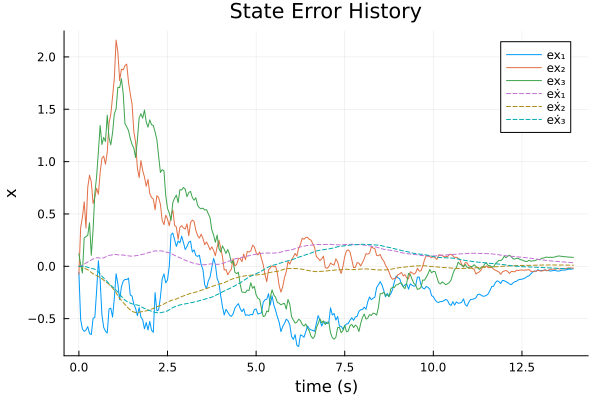

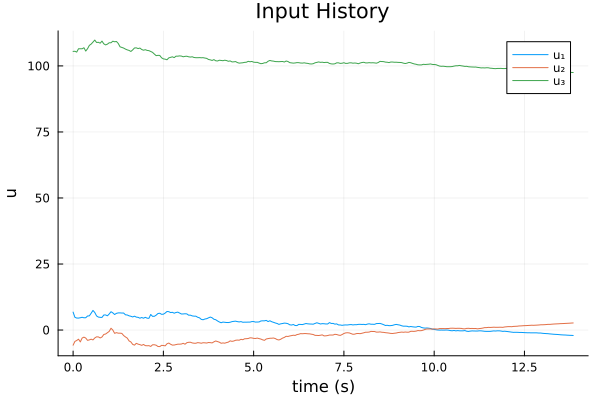

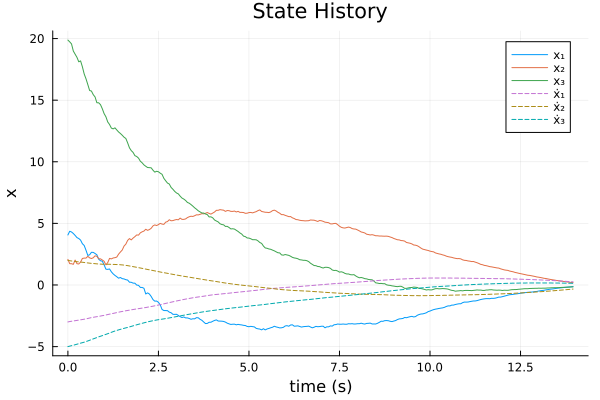

In [676]:
Xsim_m = mat_from_vec(Xhist[1:end-Nh])
Usim_m = mat_from_vec(Uhist[1:end-Nh-1])
e_sim_m = mat_from_vec(Xref[1:end-Nh]-Xhist[1:end-Nh])
@show traj_error = maximum(norm.(e_sim_m, Inf))
display(plot(t_vec[1:end-Nh],e_sim_m',label = ["ex₁" "ex₂" "ex₃" "eẋ₁" "eẋ₂" "eẋ₃"], 
             linestyle=[:solid :solid :solid :dash :dash :dash], 
             title = "State Error History",
             xlabel = "time (s)", ylabel = "x"))
display(plot(t_vec[1:end-Nh-2],Usim_m',label = ["u₁" "u₂" "u₃"],
             title = "Input History",
             xlabel = "time (s)", ylabel = "u"))
display(plot(t_vec[1:end-Nh],Xsim_m',label = ["x₁" "x₂" "x₃" "ẋ₁" "ẋ₂" "ẋ₃"], 
             linestyle=[:solid :solid :solid :dash :dash :dash],
             title = "State History",
             xlabel = "time (s)", ylabel = "x"))